# Face Recognition - Fine Tuning (GOOGLE COLAB)

In [0]:
!nvidia-smi

Thu Jun  4 18:47:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 2.x

In [0]:
!pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 9.1MB/s 


In [0]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.0


In [0]:
from keras.preprocessing import image as kimage
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization

# (Mount Google Drive from the menu on the left)

### If you want to test with your pictures: execute this (pictures2 is the folder with your pictures split in train/val/test folders, change it as needed):

In [0]:
my_pictures_dir ="/content/drive/My Drive/2D/pictures_neutral_split"

### If you want to test the code with the celebrities dataset, execute this (thumbnails_features_deduped_sample.zip is the zip file from the url in the slides with the project description):

In [0]:
# !unzip -qq "/content/drive/My Drive/2D/thumbnails_features_deduped_sample.zip"

In [0]:
# !mkdir celebrities

In [0]:
# !mv thumbnails_features_deduped_sample/* celebrities

In [0]:
# import sys
# sys.path.insert(1, '/content/drive/My Drive/2D/')

In [0]:
# import utils_2d

In [0]:
# Not enough pictures now, I will use the sample set from the Project slides
# root_dir = 'celebrities/'
# dest_dir = 'celebrities2/' # or the same as root_dir
# utils_2d.pictures_train_test_val_split(root_dir, dest_dir

In [0]:
# my_pictures_dir = dest_dir

# Define Train/test/val sets

In [0]:
train_dir = my_pictures_dir+"/train"
val_dir = my_pictures_dir+"/val"
test_dir = my_pictures_dir+"/test"

In [0]:
!ls "$my_pictures_dir/test"

alessandro  alinda  cami  gian	luca  mamma  papi  umbe


# Resnet V2

In [0]:
processing = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input)

In [0]:
train_generator = processing.flow_from_directory(train_dir,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 batch_size=32,
                                                 class_mode="categorical",
                                                 shuffle=True,
                                                 seed=1)

Found 1239 images belonging to 8 classes.


In [0]:
n_classes = (train_generator.num_classes)

In [0]:
val_generator = processing.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                color_mode="rgb",
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle=False,
                                                seed=1)


Found 354 images belonging to 8 classes.


In [0]:
test_generator = processing.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                color_mode="rgb",
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle=False,
                                                seed=1)


Found 181 images belonging to 8 classes.


### See preprocessed images

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
batch = np.array(train_generator[0][0])

In [0]:
batch.shape

(32, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


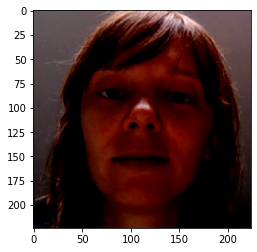

In [0]:
pic = batch[20]
plt.imshow(pic)
plt.show()

### Net

In [0]:
base_net = resnet_v2.ResNet152V2(input_shape=(224, 224, 3),
                         weights='imagenet',
                         include_top=False,
                         pooling='avg')

234553344/234545216 [==============================] - 8s 0us/step


In [0]:
for layer in base_net.layers:
  layer.trainable = False # congeliamo i layer della rete resnet_v2 di base, vogliamo solo cambiare i pesi dei layer che aggiungeremo

In [0]:
x = base_net.output
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
pred = Dense(n_classes, activation='softmax')(x)
net = Model(inputs=base_net.input, outputs=pred)

In [0]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=["accuracy"])

In [0]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

In [0]:
history = net.fit_generator(train_generator,
                  verbose=1,
                  epochs=100,
                  callbacks=[callback],
                  validation_data=val_generator)

Epoch 1/100
39/39 [==============================] - 810s 21s/step - loss: 0.0741 - accuracy: 0.9750 - val_loss: 10.0575 - val_accuracy: 0.3079
Epoch 2/100
39/39 [==============================] - 10s 255ms/step - loss: 1.8413e-04 - accuracy: 1.0000 - val_loss: 9.9258 - val_accuracy: 0.3333
Epoch 3/100
39/39 [==============================] - 10s 256ms/step - loss: 9.5987e-05 - accuracy: 1.0000 - val_loss: 14.0484 - val_accuracy: 0.6215
Epoch 4/100
39/39 [==============================] - 10s 256ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 11.6544 - val_accuracy: 0.6045
Epoch 5/100
39/39 [==============================] - 10s 255ms/step - loss: 7.6870e-04 - accuracy: 1.0000 - val_loss: 14.6435 - val_accuracy: 0.6384
Epoch 6/100
39/39 [==============================] - 10s 256ms/step - loss: 4.2412e-04 - accuracy: 1.0000 - val_loss: 8.9771 - val_accuracy: 0.5650
Epoch 7/100
39/39 [==============================] - 10s 256ms/step - loss: 7.1951e-04 - accuracy: 1.0000 - val_loss:

## Evaluation


In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

In [0]:
net.evaluate_generator(train_generator)

[2.586455821990967, 0.6101694703102112]

In [0]:
net.evaluate_generator(val_generator)

[0.5700804591178894, 0.5875706076622009]

In [0]:
net.evaluate_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


[1.421979308128357, 0.6022099256515503]

In [0]:
def classification_report_generator(generator):
  # should not be applied to generators with shuffle = True
  preds = net.predict_generator(generator)
  preds = np.argmax(preds, axis=1)
  real = generator.classes
  ind_dict = generator.class_indices
  num_to_label = [i[0] for i in ind_dict.items()]
  cmat = cm(real, preds)
  cr = classification_report(real, preds, target_names=num_to_label)
  return cmat, cr

In [0]:
cm_val, cr_val = classification_report_generator(val_generator)
print(cr_val)

              precision    recall  f1-score   support

  alessandro       0.42      1.00      0.60        70
      alinda       1.00      0.76      0.87        34
        cami       0.00      0.00      0.00        41
        gian       0.62      0.95      0.75        43
        luca       0.00      0.00      0.00        44
       mamma       0.93      1.00      0.96        41
        papi       1.00      0.39      0.56        41
        umbe       0.38      0.35      0.36        40

    accuracy                           0.59       354
   macro avg       0.54      0.56      0.51       354
weighted avg       0.52      0.59      0.51       354



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
cm_test, cr_test = classification_report_generator(test_generator)
print(cr_test)

              precision    recall  f1-score   support

  alessandro       0.43      1.00      0.61        36
      alinda       1.00      0.94      0.97        17
        cami       0.00      0.00      0.00        21
        gian       0.62      0.95      0.75        22
        luca       0.00      0.00      0.00        22
       mamma       0.95      1.00      0.98        21
        papi       1.00      0.43      0.60        21
        umbe       0.35      0.29      0.32        21

    accuracy                           0.60       181
   macro avg       0.54      0.58      0.53       181
weighted avg       0.52      0.60      0.52       181



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
import matplotlib.pyplot as plt

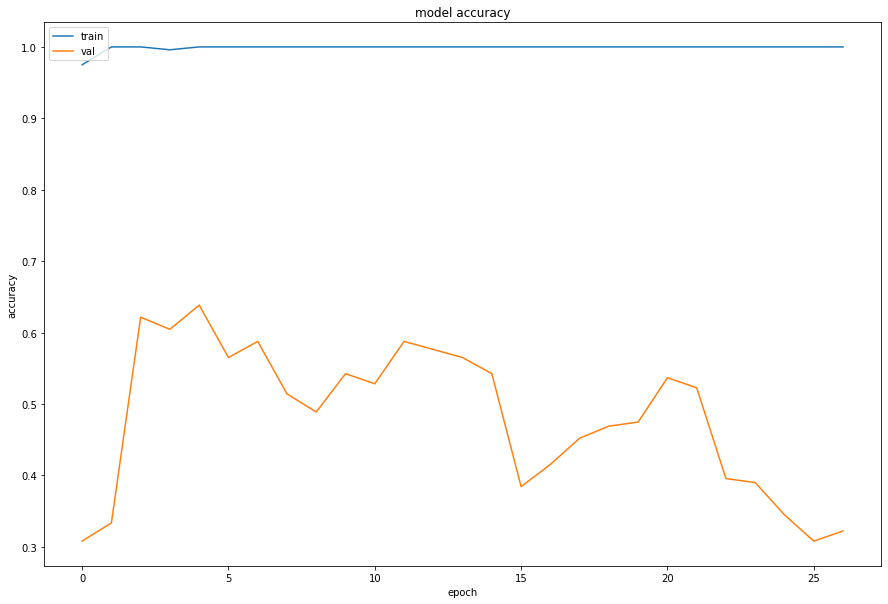

In [0]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

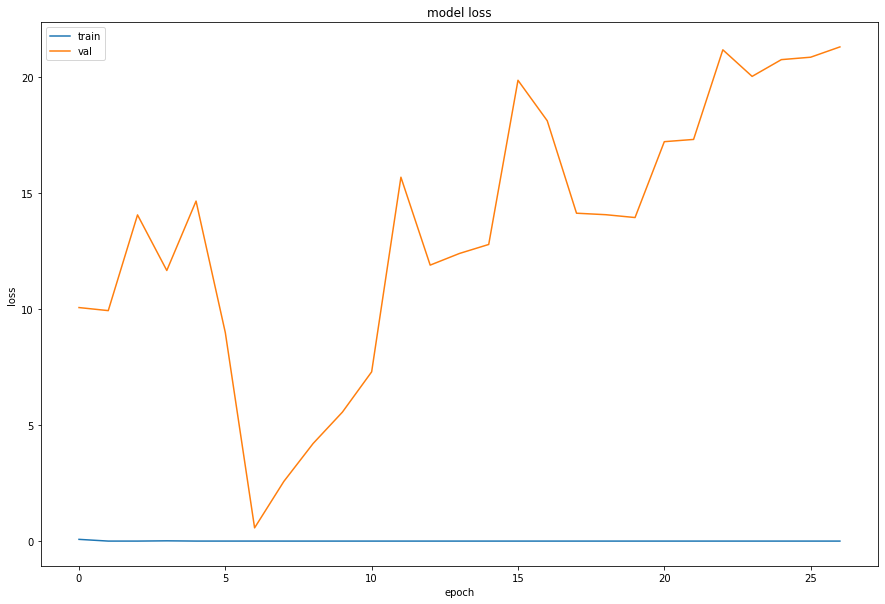

In [0]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Resnet V2 + Data Augmentation

Aggiungiamo le operazioni di data augmentation all'ImageDataGenerator di prima.

In [0]:
train_processing = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input,
                                       # featurewise_center=True,
                                       # featurewise_std_normalization=True,
                                       # zca_whitening=True,
                                       # Rotations
                                       rotation_range=40,
                                       # # Shifts
                                       width_shift_range=0.05,
                                       height_shift_range=0.05,
                                       # # Flips
                                       # horizontal_flip=True,
                                       # vertical_flip=True,
                                       # Brightness Change
                                       brightness_range=[0.9,1.1],
                                       # Zoom Change
                                       zoom_range=[0.9,1.1]
                                       )

In [0]:
train_generator = train_processing.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=1)

Found 1239 images belonging to 8 classes.


In [0]:
test_processing = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input)

val_generator = test_processing.flow_from_directory(val_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=False,
                                                    seed=1)

test_generator = test_processing.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=False,
                                                    seed=1)

Found 354 images belonging to 8 classes.
Found 181 images belonging to 8 classes.


In [0]:
base_net = resnet_v2.ResNet152V2(input_shape=(224, 224, 3),
                                 weights='imagenet',
                                 include_top=False, # eliminiamo l'ultimo layer, non ci interessa.
                                 pooling='avg')

In [0]:
for layer in base_net.layers:
  layer.trainable = False # congeliamo i layer della rete resnet_v2 di base, vogliamo solo cambiare i pesi dei layer che aggiungeremo

In [0]:
x = base_net.output
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
pred = Dense(n_classes, activation='softmax')(x)
net = Model(inputs=base_net.input, outputs=pred)

In [0]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=["accuracy"])


In [0]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

In [0]:
history = net.fit_generator(train_generator,
                  verbose=1,
                  epochs=100,
                  callbacks=[callback],
                  validation_data=val_generator)

Epoch 1/100
39/39 [==============================] - 35s 907ms/step - loss: 0.0984 - accuracy: 0.9701 - val_loss: 9.7550 - val_accuracy: 0.2345
Epoch 2/100
39/39 [==============================] - 20s 521ms/step - loss: 0.0064 - accuracy: 0.9992 - val_loss: 7.9665 - val_accuracy: 0.4153
Epoch 3/100
39/39 [==============================] - 24s 604ms/step - loss: 0.0064 - accuracy: 0.9976 - val_loss: 13.9906 - val_accuracy: 0.2119
Epoch 4/100
39/39 [==============================] - 24s 619ms/step - loss: 0.0066 - accuracy: 0.9976 - val_loss: 23.2204 - val_accuracy: 0.2232
Epoch 5/100
39/39 [==============================] - 24s 618ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 17.6472 - val_accuracy: 0.3842
Epoch 6/100
39/39 [==============================] - 24s 621ms/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 0.0309 - val_accuracy: 0.7655
Epoch 7/100
39/39 [==============================] - 23s 602ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 16.2633 - val_accur

## Evaluation


In [0]:
net.evaluate_generator(train_generator)

[0.6109487414360046, 0.700564980506897]

In [0]:
net.evaluate_generator(val_generator)

[0.03089158982038498, 0.7655367255210876]

In [0]:
net.evaluate_generator(test_generator)

[0.02369130775332451, 0.7845304012298584]

In [0]:
cm_val, cr_val = classification_report_generator(val_generator)
print(cr_val)

              precision    recall  f1-score   support

  alessandro       0.96      1.00      0.98        70
      alinda       1.00      0.47      0.64        34
        cami       1.00      1.00      1.00        41
        gian       0.00      0.00      0.00        43
        luca       1.00      0.70      0.83        44
       mamma       0.44      1.00      0.61        41
        papi       1.00      0.78      0.88        41
        umbe       0.60      1.00      0.75        40

    accuracy                           0.77       354
   macro avg       0.75      0.74      0.71       354
weighted avg       0.76      0.77      0.73       354



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
cm_test, cr_test = classification_report_generator(test_generator)
print(cr_test)

              precision    recall  f1-score   support

  alessandro       0.97      1.00      0.99        36
      alinda       1.00      0.59      0.74        17
        cami       1.00      1.00      1.00        21
        gian       1.00      0.05      0.09        22
        luca       1.00      0.82      0.90        22
       mamma       0.44      1.00      0.61        21
        papi       1.00      0.67      0.80        21
        umbe       0.66      1.00      0.79        21

    accuracy                           0.78       181
   macro avg       0.88      0.76      0.74       181
weighted avg       0.89      0.78      0.76       181



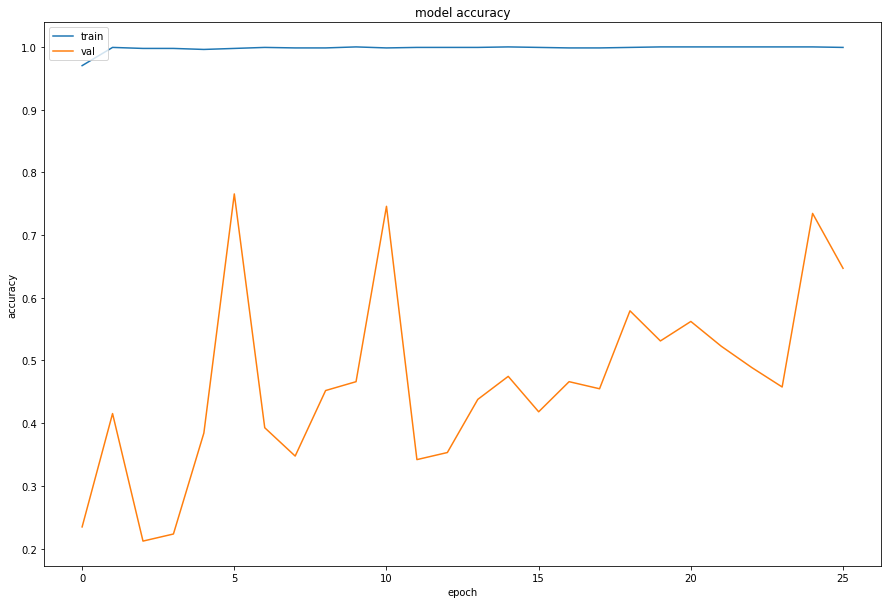

In [0]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

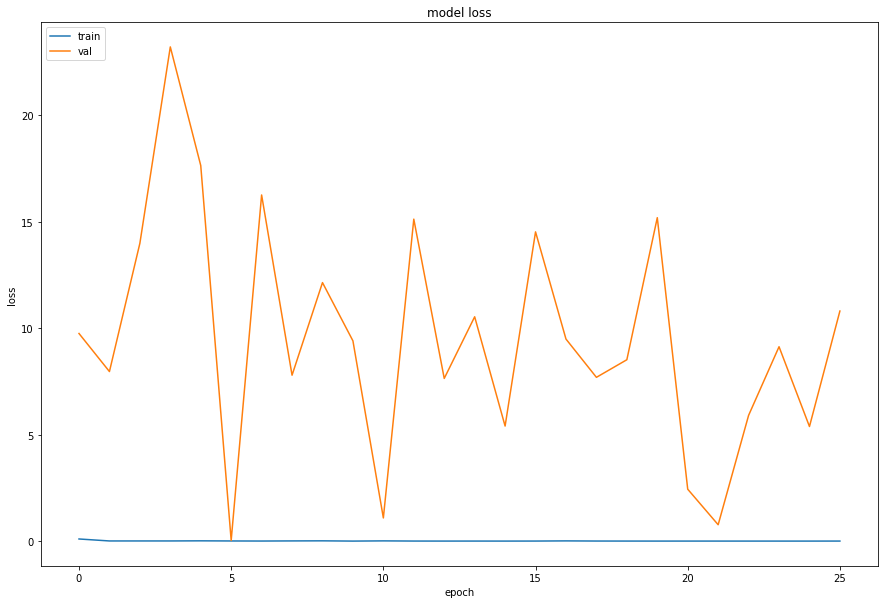

In [0]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model_name = 2
model_filename = f"/content/drive/My Drive/2D/models/{model_name}_model.h5"
model_filename

'/content/drive/My Drive/2D/models/2_model.h5'

In [0]:
net.save(model_filename)

# TODO

- Collect more data
- Choose a better model
- look at these: 
  - https://github.com/Golbstein/keras-face-recognition
  - https://github.com/krasserm/face-recognition